In [15]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join('..')))

In [16]:
import src.data.organize_data as od

features_list = ['t0', 't1', 't2', 'a0', 'a1', 'a2', 'b0', 'b1', 'b2', 'c0', 'c1', 'c2', 'dicnotch', 'winSys', 'maxAmpl', 'sysTime', 'duration',  'Es', 'As', 'Ed', 'Ad', 'td', 'fd', 'R2_of_fit']
feature_data_path  = r"C:\Users\cical\Documents\GitHub\Repositories\tesina\data\interim\feature_extracted"

feature_df = od.organize_data2(feature_data_path, features_list)

c:\Users\cical\Documents\GitHub\Repositories\tesina_modelli\src\data\organize_data.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, data_df], ignore_index=True)


# Data Pre-Processing

## Split Dataset

In [17]:
import src.data.organize_data as od

X_train, X_test, y_train, y_test = od.split_train_test(feature_df, 'Group', 0.2)

## Data selection (outliers and p-value)

In [18]:
import src.data.data_selection as ds

X_train, y_train = ds.filter_outliers_by_group(X_train, y_train, features_to_ignore=['PatientID', 'SignalID', 'R2_of_fit', 'pulse_index'])

X_train, y_train = ds.filter_fit_value(X_train, y_train, 0.9, 'R2_of_fit')

INFO:root:Removed 699 rows for label covid_Empoli_60
INFO:root:Removed 981 rows for label healthyControl_Empoli_60
INFO:root:Removed 6260 rows for label mentalDisorders_MIMIC_125
INFO:root:Removed 4780 rows for label sepsis_MIMIC_125


## Data Trasformation

### Patient median

In [19]:
import src.data.data_preprocessing as dp

X_train, y_train = dp.calculate_patient_median(X_train, y_train, 'SignalID', features_list)
X_test, y_test = dp.calculate_patient_median(X_test, y_test, 'SignalID', features_list)


X_train.drop(columns=['SignalID',  'R2_of_fit'], inplace=True)
X_test.drop(columns=['SignalID',   'R2_of_fit'], inplace=True)

### SMOTE+EEN

In [20]:
import src.data.data_preprocessing as dp
import src.visualization.visualize as vis

#vis.plot_class_distribution(y_train, title="Distribution before SMOTEEN")

#X_train, y_train = dp.balance_dataset(X_train, y_train)

#vis.plot_class_distribution(y_train, title="Distribution after SMOTEEN")

### Scaling


In [21]:
import src.data.data_preprocessing as dp
import src.visualization.visualize as vis

X_train = dp.scale_numeric_features(X_train)
X_test = dp.scale_numeric_features(X_test)

df = X_train.copy()
df['Group'] = y_train

# Statistical tests

## Shapiro-Wilk test

c:\Users\cical\Documents\GitHub\Repositories\tesina_modelli\src\statistics\tests_normality.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame([{'Feature': feature, 'Group': group, 'Statistic': stat, 'P-value': p_value}])], ignore_index=True)


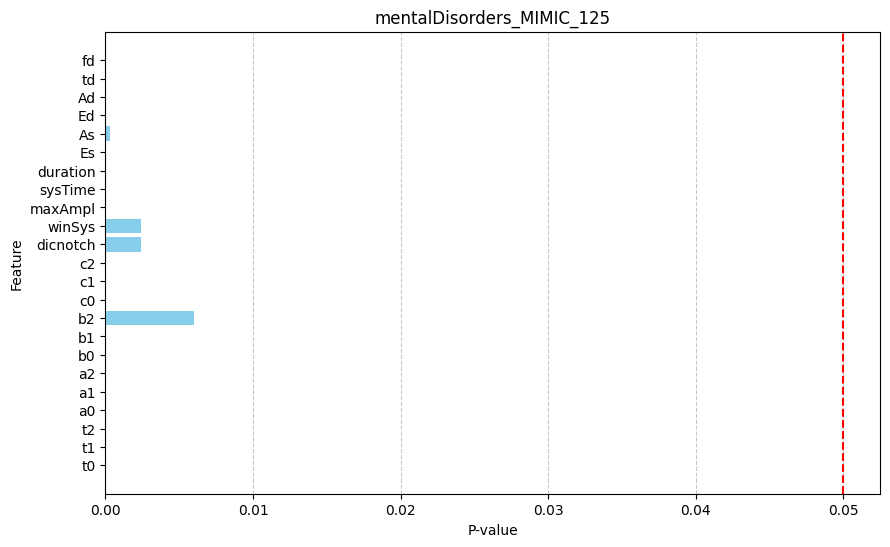

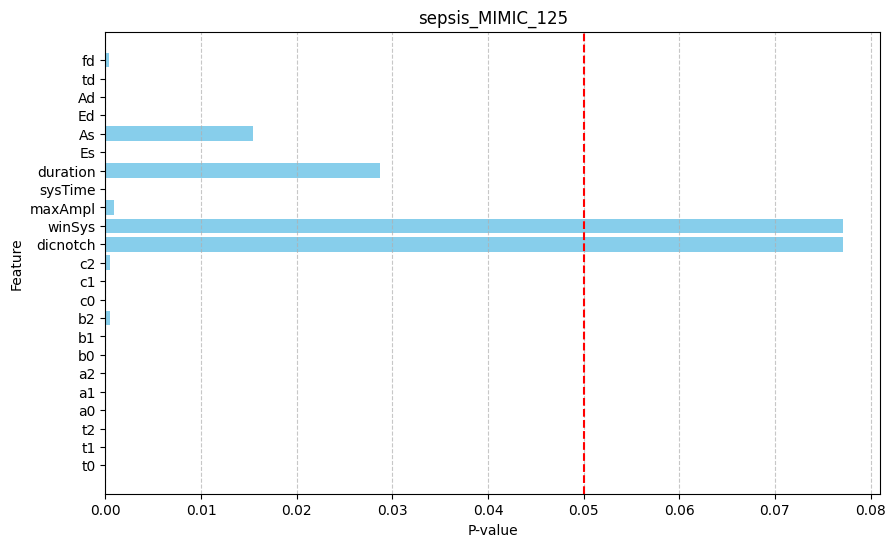

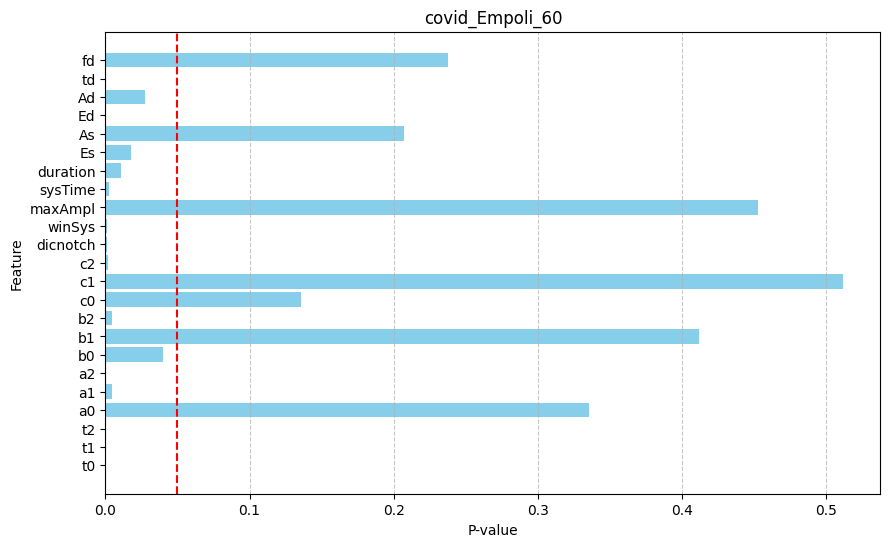

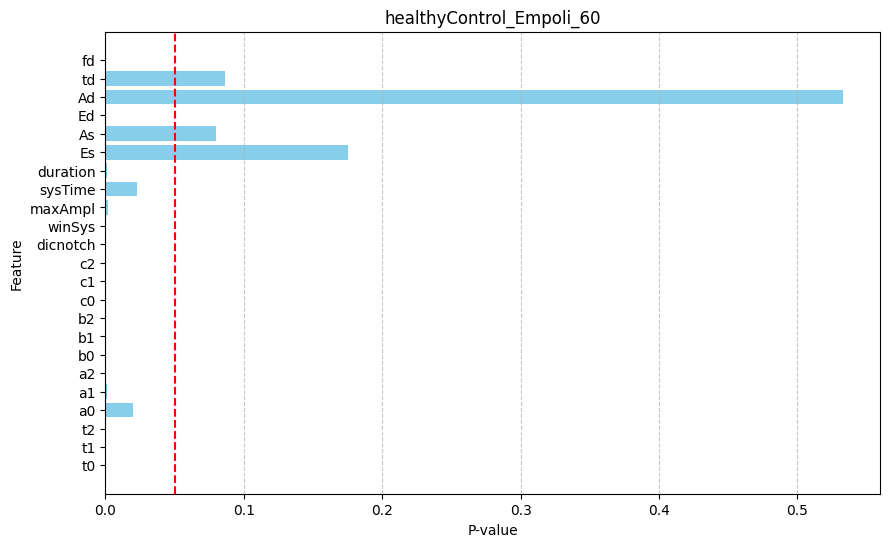

In [22]:
import src.statistics.tests_normality as nt
import src.visualization.visualize as vis

normality_test = nt.shapiro_test(X_train, y_train)

for group in normality_test['Group'].unique():
    sub_df = normality_test[normality_test['Group'] == group]
    vis.plot_pvalues(sub_df, group)

## Friedman test

c:\Users\cical\Documents\GitHub\Repositories\tesina_modelli\src\statistics\tests_difference.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame([{'Feature': feature, 'Group': group, 'Statistic': f_statistic, 'P-value': p_value}])], ignore_index=True)


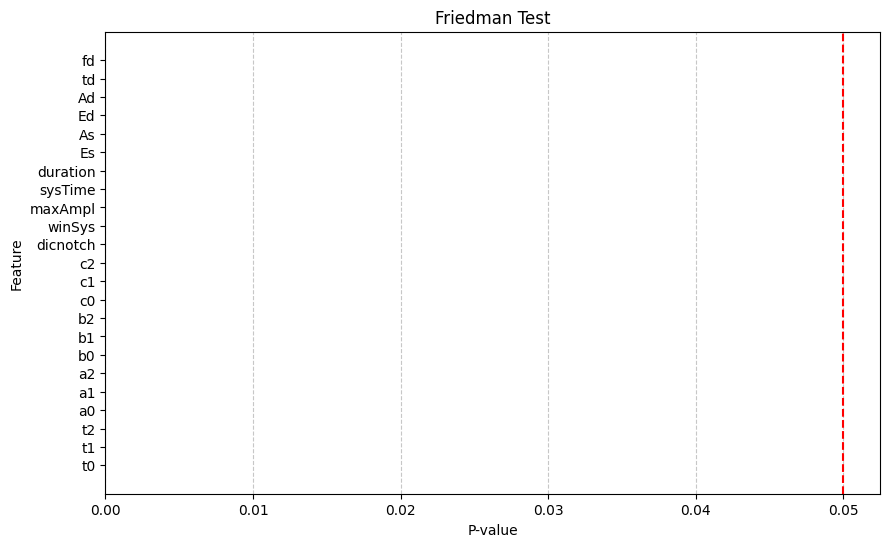

In [23]:
import src.statistics.tests_difference as td
import src.visualization.visualize as vis

friedman_test = td.friedman_test(X_train, y_train)

vis.plot_pvalues(friedman_test, 'Friedman Test')


## Post-hoc Mann-Whitney U

In [24]:
import src.statistics.tests_difference as td

# valuto differenze tra gruppi per le features significative del test di Friedman
significant_features = friedman_test[friedman_test['P-value'] < 0.05]['Feature'].tolist()
significant_features_dict = td.pairwise_mann_whitney_test(X_train, y_train, significant_features=significant_features)

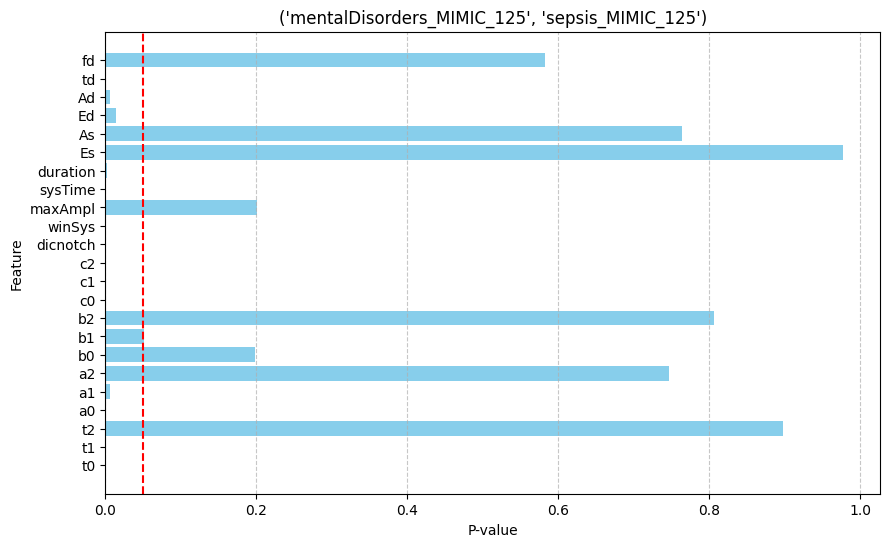

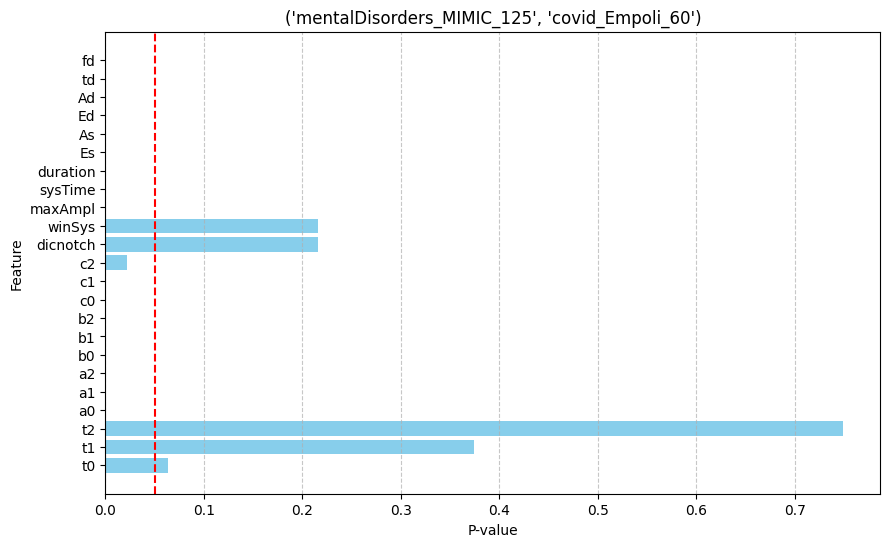

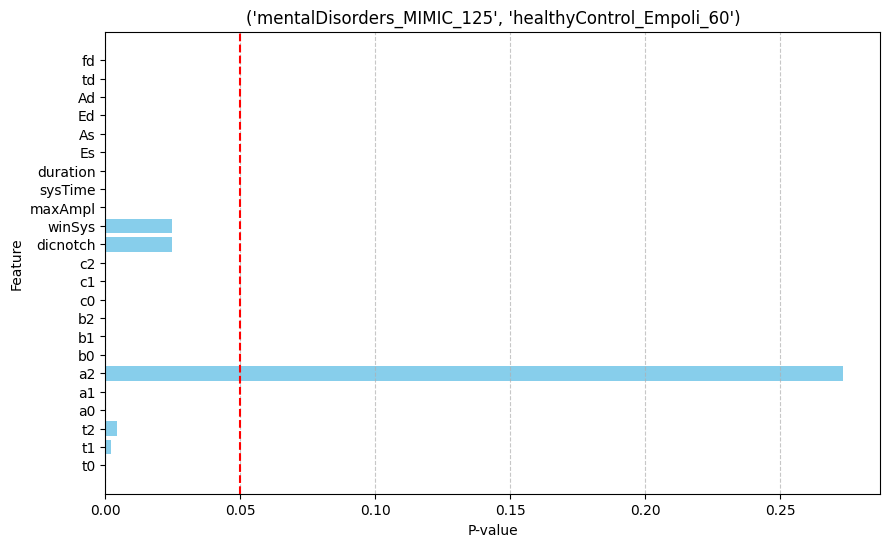

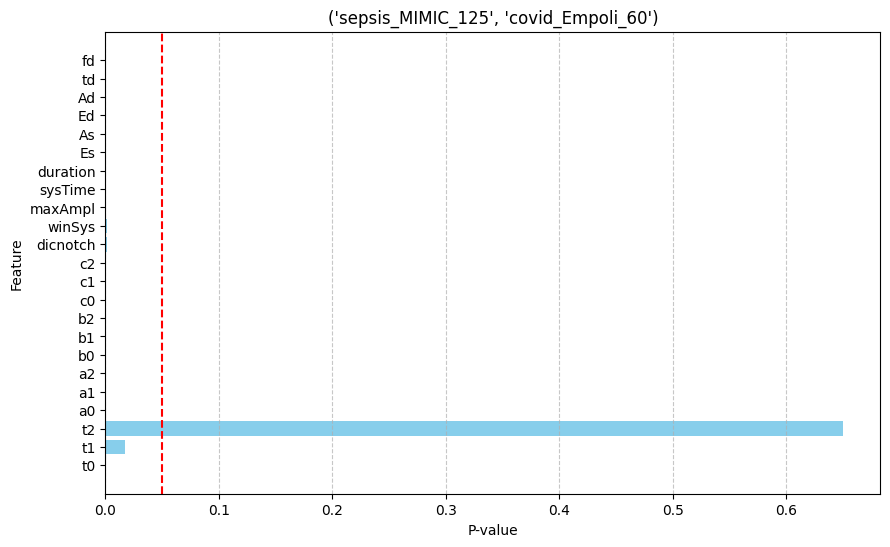

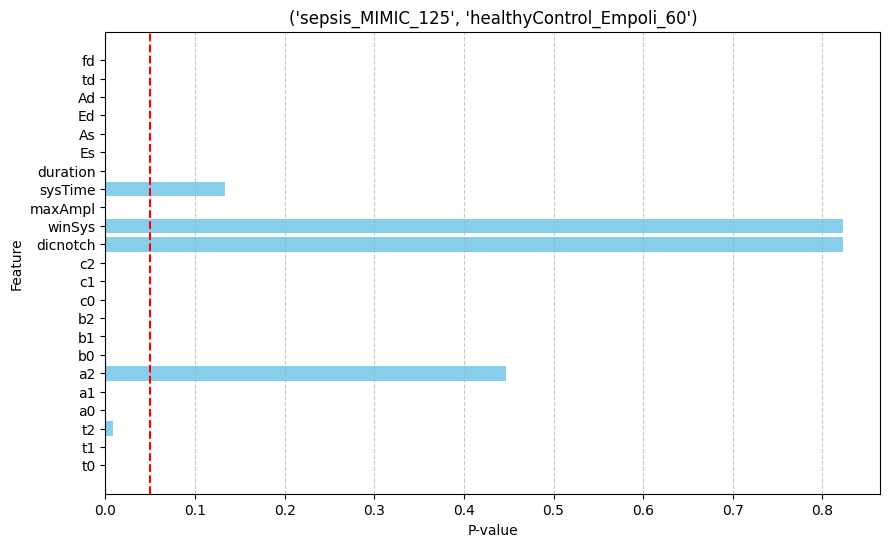

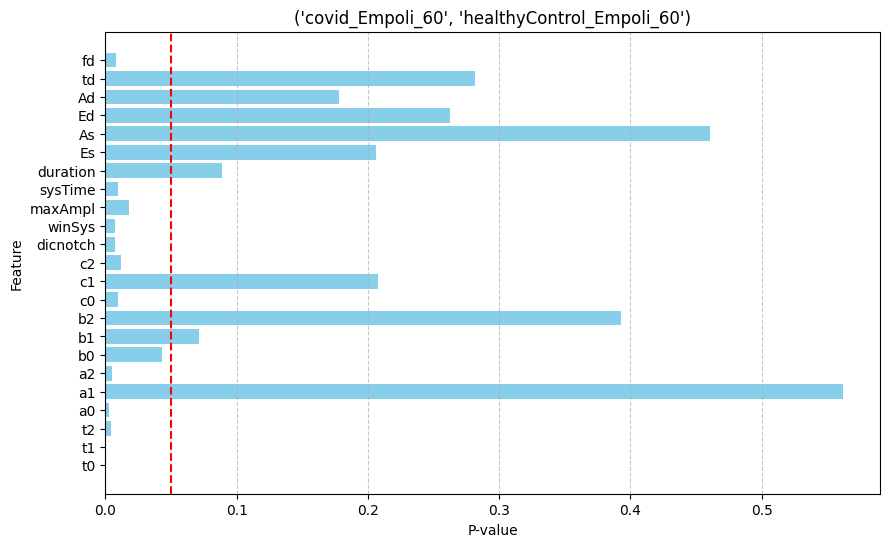

In [25]:
import src.visualization.visualize as vis

for group_pair, result in significant_features_dict.items():
    vis.plot_pvalues(result, group_pair)

## Unified dataset

Si cercano differenze tra il gruppo di sani (health e soggetti con disturbi mentali) e il gruppo di malati (sepsi e covid)

c:\Users\cical\Documents\GitHub\Repositories\tesina_modelli\src\statistics\tests_difference.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([{'Feature': feature, 'Group': group, 'Statistic': u_statistic, 'P-value': p_value}])], ignore_index=True)


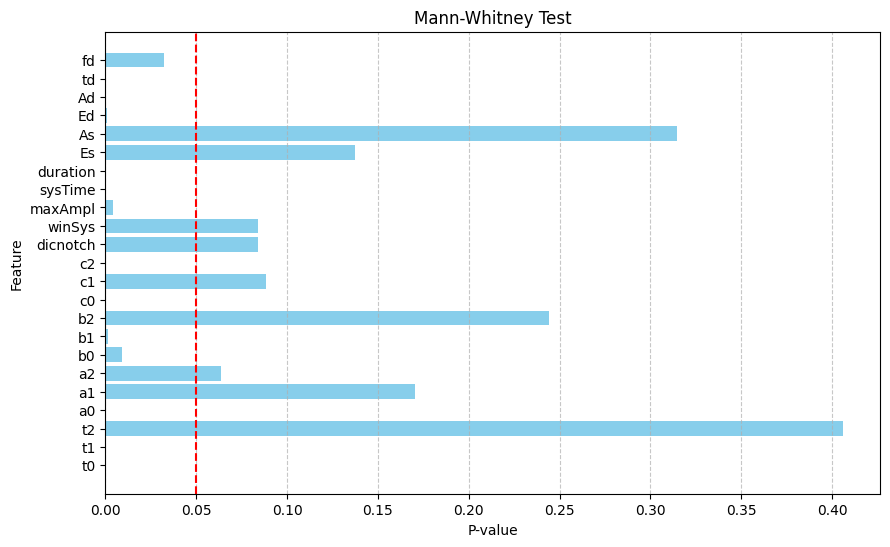

In [26]:
import src.statistics.tests_difference as td
import src.visualization.visualize as vis

y_train_unified = y_train.copy()

# Mappa i valori della colonna 'Group' come richiesto
mapping = {'covid_Empoli_60': "sick", 'sepsis_MIMIC_125': "sick",
           'healthyControl_Empoli_60': "healthy", 'mentalDisorders_MIMIC_125': "healthy"}
y_train_unified = y_train_unified.replace(mapping)

unified_result = td.mann_whitney_test(X_train, y_train_unified)

vis.plot_pvalues(unified_result, 'Mann-Whitney Test')

# Training Model

## Primo test (Health vs Ill)

Nel primo test si cerca di addestrare un modello che permetta di identificare tra gruppo di sani (heamth and mental disorders) e patologici (covid o sepsi). 
A questo scopo vengono utilizzate le features con un valore di p-value al di sotto della soglia impostata del test di mann-Whitney per il dataset unificato.

In [27]:
features_test_1 = unified_result[unified_result['P-value'] < 0.05]['Feature'].tolist()

X_train_t1 = X_train[features_test_1]
X_test_t1 = X_test[features_test_1]

y_train_t1 = y_train.map({'covid_Empoli_60': 'ill', 'sepsis_MIMIC_125': 'ill', 
                              'healthyControl_Empoli_60': 'health', 'mentalDisorders_MIMIC_125': 'health'})

y_test_t1 = y_test.map({'covid_Empoli_60': 'ill', 'sepsis_MIMIC_125': 'ill', 
                              'healthyControl_Empoli_60': 'health', 'mentalDisorders_MIMIC_125': 'health'})

### Cross validation

Si effettua una cross validazione con StratifiedKFold (cv=5) e si valutano le performance dei modelli per f1_macro e il coeff. di correlazioen di Matthews. I tre modelli che presentano le prestazioni migliori veranno poi migliorati con un ottizzazione degli iperparametri.

In [28]:
import src.models.model as models
import src.models.evaluation as ev

models = models.define_models()
metric_results = ev.evaluate_models(X_train_t1, y_train_t1, models, None)



Models Evaluation with f1_macro:  29%|██▊       | 2/7 [00:59<02:29, 29.91s/it]


KeyboardInterrupt: 

In [ ]:
import src.models.evaluation as ev

optimal_parameters_t1 = ev.evaluate_optimized_models(X_train_t1, y_train_t1, metric_results, metric='f1_macro')

### Training and test fine tuned model

In [ ]:
import src.models.model as md
import src.visualization.visualize as vis

trained_model_t1 = md.train_model_with_optimal_params('svm', optimal_parameters_t1, X_train_t1_reduced, y_train_t1)

vis.plot_model_performance(trained_model_t1, X_test_t1_reduced, y_test_t1, 'f1-score')

## Secondo test (ill)

In questo caso viene addestrato un modello che deve riconoscere i pazienti affetti da covid da quelli affetti da sepsi

In [ ]:
import src.data.data_selection as ds

try:
    result_statistical_ill = significant_features_dict[('covid_Empoli_60', 'sepsis_MIMIC_125')]
except KeyError:
    result_statistical_ill = significant_features_dict[('sepsis_MIMIC_125', 'covid_Empoli_60')]
    
features_test_2 = result_statistical_ill[result_statistical_ill['P-value'] < 0.05]['Feature'].tolist() 

#features_test_2 = list(set(unified_result[unified_result['P-value'] > 0.05]['Feature'].tolist()).intersection(features_test_2))

X_train_t2 = X_train[features_test_2]
X_test_t2 = X_test[features_test_2]

# si rimuovono le righe relative ai gruppi 'healthyControl_Empoli_60' e 'mentalDisorders_MIMIC_125'
target_values = ['covid_Empoli_60', 'sepsis_MIMIC_125']
X_train_t2, y_train_t2 = ds.filter_rows_by_values(X_train_t2, y_train, target_values)
X_test_t2, y_test_t2 = ds.filter_rows_by_values(X_test_t2, y_test, target_values)



### Dimensionality Reduction

In [ ]:
import src.features.dimensionality_reduction as dr

X_train_t2_reduced, X_test_t2_reduced = dr.reduce_dimensionality(X_train_t2, X_test_t2, 'PCA', n_components=2)

### Cross-validation

In [ ]:
import src.models.model as models
import src.models.evaluation as ev

models = models.define_models()
metric_results = ev.evaluate_models(X_train_t2_reduced, y_train_t2, models)

ev.summarize_results(metric_results)

In [ ]:
import src.models.evaluation as ev

optimal_parameters_t2 = ev.evaluate_optimized_models(X_train_t2_reduced, y_train_t2, metric_results, metric='f1_macro', cv=5)

### Training and test fine tuned model

In [ ]:
import src.models.model as md
import src.visualization.visualize as vis

trained_model = md.train_model_with_optimal_params('catboost', optimal_parameters_t2, X_train_t2_reduced, y_train_t2)

vis.plot_model_performance(trained_model, X_test_t2_reduced, y_test_t2, 'f1-score')

## Test 3 (Health)

Viene addestrato un modello con lo scopo di identificare i pazienti sani da quelli con disturbi mentali

In [ ]:
import src.data.data_selection as ds

result_statistical_health = significant_features_dict[('mentalDisorders_MIMIC_125', 'healthyControl_Empoli_60')]
features_test_3 = result_statistical_health[result_statistical_health['P-value'] < 0.05]['Feature'].tolist()

#features_test_3 = list(set(unified_result[unified_result['P-value'] > 0.05]['Feature'].tolist()).intersection(features_test_3))

X_train_t3 = X_train[features_test_3]
X_test_t3 = X_test[features_test_3]

# si rimuovono le righe relative ai gruppi 'covid_Empoli_60' e 'sepsis_MIMIC_125'
target_values = ['mentalDisorders_MIMIC_125', 'healthyControl_Empoli_60']
X_train_t3, y_train_t3 = ds.filter_rows_by_values(X_train_t3, y_train, target_values)
X_test_t3, y_test_t3 = ds.filter_rows_by_values(X_test_t3, y_test, target_values)

### Dimensionality reduction

In [ ]:
import src.features.dimensionality_reduction as dr

X_train_t3_reduced, X_test_t3_reduced = dr.reduce_dimensionality(X_train_t3, X_test_t3, 'PCA', n_components=2)

### Cross-validation

In [ ]:
import src.models.model as models
import src.models.evaluation as ev

models = models.define_models()
metric_results = ev.evaluate_models(X_train_t3_reduced, y_train_t3, models)

ev.summarize_results(metric_results)

In [ ]:
import src.models.evaluation as ev

optimal_parameters_t3 = ev.evaluate_optimized_models(X_train_t3_reduced, y_train_t3, metric_results, metric='f1_macro', cv=5)

### Training e test fine tuned model

In [ ]:
import src.models.model as md
import src.visualization.visualize as vis

trained_model = md.train_model_with_optimal_params('mlp', optimal_parameters_t3, X_train_t3_reduced, y_train_t3)

vis.plot_model_performance(trained_model, X_test_t3_reduced, y_test_t3, 'f1-score')

## Test 4 (All)

In [ ]:
features_test_4 = friedman_test[friedman_test['P-value'] < 0.05]['Feature'].tolist()

X_train_t4 = X_train[features_test_4]
X_test_t4 = X_test[features_test_4]

y_train_t4 = y_train.copy()
y_test_t4 = y_test.copy()

### Dimensionality Reduction

In [ ]:
import src.features.dimensionality_reduction as dr

X_train_t4_reduced, X_test_t4_reduced = dr.reduce_dimensionality(X_train_t4, X_test_t4, 'PCA', n_components=2)

### Cross-validation

In [ ]:
import src.models.model as models
import src.models.evaluation as ev

models = models.define_models()
metric_results = ev.evaluate_models(X_train_t4_reduced, y_train_t4, models)

ev.summarize_results(metric_results)

In [ ]:
import src.models.evaluation as ev

optimal_parameters_t4 = ev.evaluate_optimized_models(X_train_t4_reduced, y_train_t4, metric_results, metric='f1_macro', cv=5)

### Training and test fine tuned model

In [ ]:
import src.models.model as md
import src.visualization.visualize as vis

trained_model = md.train_model_with_optimal_params('rf', optimal_parameters_t4, X_train_t4_reduced, y_train_t4)

vis.plot_model_performance(trained_model, X_test_t4_reduced, y_test_t4, 'f1-score')